In [5]:
!pip install pyDOE

In [6]:
import torch
from tqdm import tqdm

class PINN(torch.nn.Module):
    
    def __init__(self, layers = [10,10], device = None):
        super(PINN, self).__init__() # inherit methods from torch
        
        # set to use GPU
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device
            
        # store hidden layer activation function
        self.hidden_activation = torch.nn.Tanh().to(device)
        
        # initialize nn architecture:
        self.input_layer = torch.nn.Linear(2,layers[0]).to(device)
        self.input_activation = torch.nn.Tanh().to(device)
        self.hidden = torch.nn.ModuleList([torch.nn.Linear(layers[i], layers[i+1]).to(device) for i in range(len(layers)-1)])
        self.output_layer = torch.nn.Linear(layers[-1],1).to(device)
        self.output_activation = torch.nn.Tanh().to(device)
        
        
        # init weights and biases:
        
        torch.nn.init.xavier_normal_(self.input_layer.weight.data, gain=1.0)
        torch.nn.init.zeros_(self.input_layer.bias.data)
        
        for i in range(len(layers) - 1):
            
            # set weights from normal distribution 
            torch.nn.init.xavier_normal_(self.hidden[i].weight.data, gain=1.0)
            
            # init biases as zero
            torch.nn.init.zeros_(self.hidden[i].bias.data)
            
        torch.nn.init.xavier_normal_(self.output_layer.weight.data, gain=1.0)
        torch.nn.init.zeros_(self.output_layer.bias.data)
        
        
    def forward(self, x_in): 
        
        # convert to tensor
        if torch.is_tensor(x_in) != True:         
            x_in = torch.from_numpy(x_in)
        
        # input layer
        x = self.input_layer(x_in)
        x = self.input_activation(x)
        
        # loop through hidden layers
        for i in range(len(self.hidden)):
            x = self.hidden_activation(self.hidden[i](x))
        
        x_out = self.output_layer(x)
        #x_out = self.output_activation(x_out)
        
        return x_out
        
    def MSE(self, y_pred, y_test):
        return torch.mean((y_pred - y_test)**2)
    
    def init_weights(self, shape):
        d_in = shape[0]
        d_out = shape[1]
        var = torch.tensor([2.0/(d_in + d_out)])
        std = torch.sqrt(var)
        mean = torch.tensor([0.0])
        dist = torch.distributions.normal.Normal(mean, std)
        return dist.sample(shape)
    
    def train_step(self, closure = True):
        
        if closure:
            self.optimizer.zero_grad()
            
        # predict solution to boundary condition
        bc_pred = self.forward(self.x_bc) #[x,t]
        self.mse_u = self.MSE(bc_pred, self.u_bc)
        #self.loss_u.append([i, self.mse_u])
        
        # predict u w/ network
        self.x.requires_grad = True 
        u_pred = self.forward(self.x)
        
        # differentiate using auto grad:
        
        # 1st deriv wrt X = [x,t]
        deriv1 = torch.autograd.grad(u_pred,
                                    self.x, # [x,t]
                                    torch.ones([self.x.shape[0], 1]).to(self.device),
                                    retain_graph = True,
                                    create_graph = True)[0]
        
        # 2nd deriv wrt X
        deriv2 = torch.autograd.grad(deriv1,
                                    self.x, 
                                    torch.ones(self.x.shape).to(self.device),
                                    create_graph = True)[0]
        
        
        du_dx = deriv1[:,[0]]
        du_dt = deriv1[:,[1]]
        
        d2u_dx2 = deriv2[:,[1]] 
        d2u_dt2 = deriv2[:,[0]] 
        
        # diffusion rate
        # dimensionless problem ( k embedded in t)
        f = du_dt - 0.01*d2u_dx2
        
        self.mse_f = self.MSE(f, self.f_hat)
        self.loss = self.mse_u + self.mse_f
        
        if closure:
            self.loss.backward()
            
        return self.loss
    
    def train(self, x_bc, u_bc, x,
              learning_rate = 1e-4,
              epochs = int(1e4)):
        
        # declare variables
        self.x_bc = x_bc if torch.is_tensor(x_bc) else torch.from_numpy(x_bc).float().to(device)  
        self.u_bc = u_bc if torch.is_tensor(u_bc) else torch.from_numpy(u_bc).float().to(device)
        self.x = x if torch.is_tensor(x) else torch.from_numpy(x).float().to(device)
        self.f_hat = torch.zeros(x.shape[0],1).to(device) # PDE Loss is minimized to zero
        
        # loss history
        self.loss_u = []
        self.loss_f = []
        loss_t = []
        
        # send pinn to device
        self.to(self.device)

        self.optimizer = torch.optim.LBFGS(self.parameters(), lr=0.2, 
                              max_iter = 200, 
                              max_eval = None, 
                              tolerance_grad = 1e-05, 
                              tolerance_change = 1e-09, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe') 
        self.optimizer.step(self.train_step)
        
        optimizer = torch.optim.Adam(self.parameters(), 
                       lr= learning_rate,
                       betas=(0.9, 0.999), 
                       eps=1e-08, 
                       weight_decay=0, 
                       amsgrad=False)
        
        for i in tqdm(range(epochs)):
            
            loss = self.train_step(closure = False)
            loss_t.append(loss)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        return loss_t
    
    def predict(self, x_test):
        
        if torch.is_tensor(x_test) != True: 
            x_test = torch.from_numpy(x_test).float().to(device)
        
        u_pred = self.forward(x_test) 
        u_pred = u_pred.cpu().detach().numpy()
        u_pred = np.reshape(u_pred,(256,1001),order='F')
        
        return u_pred
    
    def error(self, x_test, y_true):
        u_pred = self.forward(x_test)
        return (torch.linalg.norm((y_true-u_pred),2)/torch.linalg.norm(y_true,2)).item()

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
plt.rcParams['figure.figsize'] = [15, 10]

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)


In [8]:
x = np.linspace(0,1,256).reshape(-1,1)                                 
t = np.linspace(0,100,1001).reshape(-1,1)

X, T = np.meshgrid(x,t)

test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# bounds
lb = test[0]  
ub = test[-1] 

L = 1

In [9]:
def trainingdata(N_u,N_f):

    #Initial Condition 0 =< x =<1 and t = 0 is a sin function
    initial_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
    initial_u = np.sin((np.pi/L)*x.reshape(-1,1))
    
    #Boundary Condition x = 0, u = 0
    bottom_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
    #bottom_u = usol[-1,:][:,None]
    bottom_u = np.zeros(t.shape)

    #Boundary Condition x = 1, u = 0
    top_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
    top_u = np.zeros(t.shape)
    
    all_bc_x = np.vstack([initial_x, bottom_x, top_x]) 
    all_bc_u = np.vstack([initial_u, bottom_u, top_u]) 

    #choose random N_u points for training
    idx = np.random.choice(all_bc_x.shape[0], N_u, replace=False) 

    bc_x = all_bc_x[idx, :] 
    bc_u = all_bc_u[idx,:]      
    
    f_x = lb + (ub-lb)*lhs(2,N_f) 
    f_x = np.vstack((f_x, bc_x))

    return f_x, bc_x, bc_u

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

'Generate Training data'
N_u = 200 #Total number of data points for 'u'
N_f = 10000 #Total number of collocation points 
f_x, bc_x, bc_u = trainingdata(N_u,N_f)

test_tensor = torch.from_numpy(test).float().to(device)

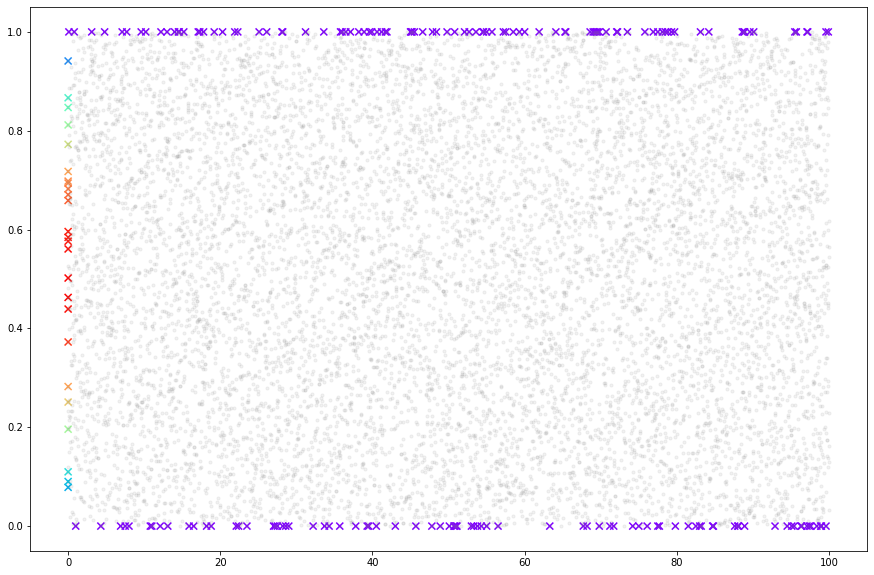

In [11]:
plt.scatter(bc_x[:,1],bc_x[:,0].T, c = bc_u, marker = 'x', s = 50, cmap = 'rainbow')
plt.scatter(f_x[:,1], f_x[:,0].T, alpha = 0.1, s = 10, c = 'gray')

In [12]:
import time
l1 = [50,50,50,50,50,50,50,50,50,50]
l2 = [20,20,20,20,20,20,20,20,20]
l3 = [20,50,100,100,100,100,100,100,50,20]

pinn = PINN(layers = l1)  

t1 = time.time()
for i in range(6):
    
    'Generate Training data'
    N_u = 100
    N_f = 10000 
    f_x, bc_x, bc_u = trainingdata(N_u,N_f)
    
    test_tensor = torch.from_numpy(test).float().to(device)
    
    loss = pinn.train(bc_x, bc_u, f_x,
                  epochs = 250)
    
print(time.time() - t1)

100%|██████████| 250/250 [01:39<00:00,  2.52it/s]

1085.2692523002625


In [13]:
u_pred = pinn.predict(test)

In [14]:
bc_x = torch.from_numpy(bc_x).float().to(device)
bc_u = torch.from_numpy(bc_u).float().to(device)

u_pred = pinn.predict(test)

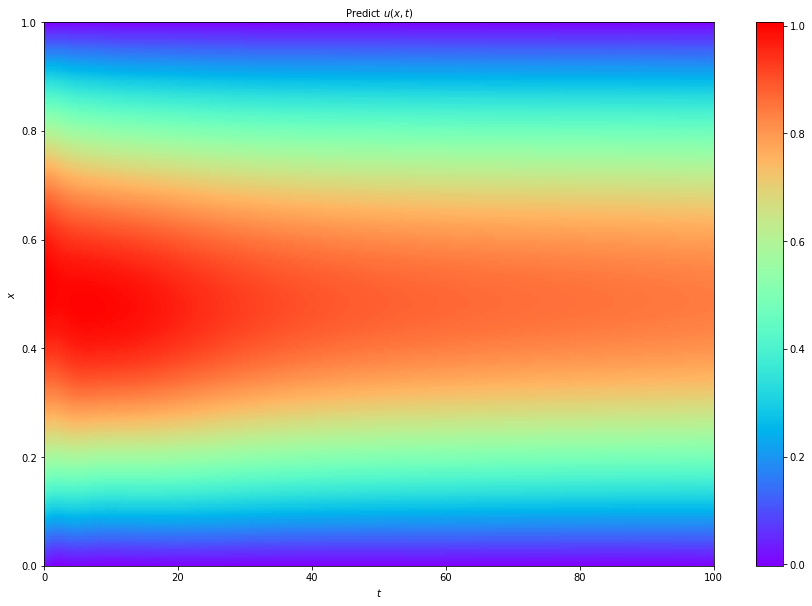

In [15]:
plt.pcolormesh(T,X,u_pred.T, cmap = 'rainbow')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predict $u(x,t)$', fontsize = 10)
plt.show()

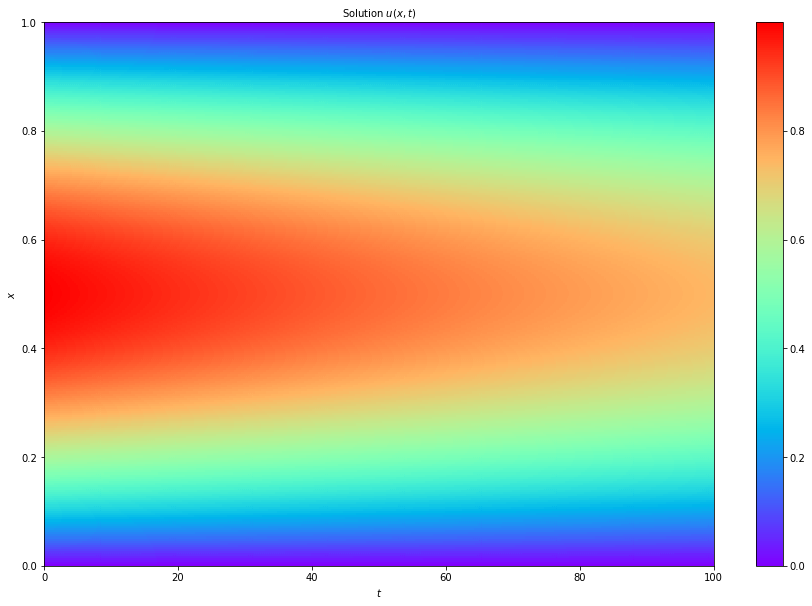

In [16]:
# DIMENSIONLESS PROBLEM
# set k = 1.1 cm^2 / s
# k embeded in t
# t_dimensionless = t / Tstar
# Tstar = L^2 / k
# If L = 1 and assume k = ( 1 / 100**2 ) --- > metal
# t is proportonal to ( 1/100**2 )

def sinsol(x,t):
    u_0 = 1
    L = 1
    k = 3 # no k in eqn or k embedded in t - but for visualisation let's include it in exp part of solution
    sol = u_0 * np.sin(((np.pi * x)/ L)) * np.exp(-k*((np.pi/L)**2)*(t/100**2))
    return sol

usol = sinsol(X,T).T

plt.pcolormesh(T,X,usol.T, cmap = 'rainbow')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Solution $u(x,t)$', fontsize = 10)
plt.show()

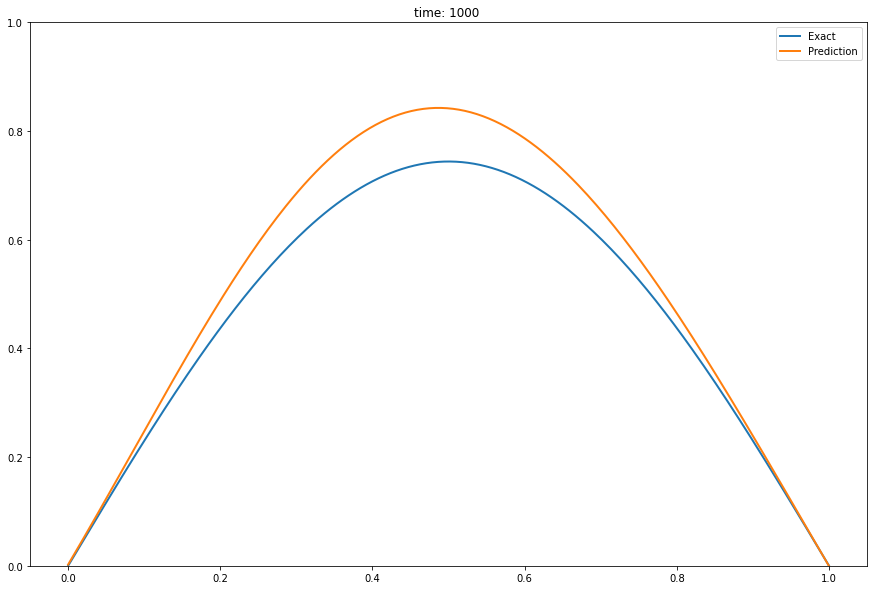

In [17]:
from IPython.display import clear_output

time_space = np.arange(0,1100,100)

for time_t in time_space:
    
    plt.plot(x,usol.T[time_t,:], linewidth = 2, label = 'Exact')
    plt.plot(x,u_pred.T[time_t,:], linewidth = 2, label = 'Prediction')
    plt.ylim([0,1])
    plt.title('time: {} '.format(time_t))
    plt.legend()
    plt.show()
    clear_output(wait=True)

In [18]:
# def rod(x,t):
#     summ = sum( [(np.sin((2*n - 1)*np.pi*x)/(2*n - 1)) * np.exp( - ((2*n - 1)**2) * (np.pi**2) * t ) for n in range(1,1000)] )
#     sol = ((4*u_0)/np.pi) * summ
#     return sol
    
# #usol = rod(X,T).T

In [ ]:
#np.exp(-1*((np.pi/2)**2)*0.5) 

In [ ]:
#print(usol.shape)
#usoll = sinsol(X,T)
#usoll.shape

In [ ]:
#u_pred.shape